## CNN for 2D xy images

In [2]:
%matplotlib inline 
#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [3]:
import random            as random
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt

In [4]:
import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#from torchsummary import summary

In [5]:
import cnn.data_xyimg as xyimg
import cnn.cnn_xyimg  as cnn

## Test

In [9]:
pressure = '2bar'
width    = 16
ifile = 'xyimg_'+pressure+'_'+str(width)+'.npz'
labels = ['esum','ecount','emax','emean','estd','zmean','zstd']
box = cnn.run(xyimg.path + ifile, labels, ofilename = 'roc_'+pressure+'_ez'+str(width))

Input data  /scratch/next/data/NEXT100/pressure_topology/xyimg_2bar_16.npz
x shape  (117085, 7, 16, 16)
y shape  (117085, 1)
torch.Size([200, 7, 16, 16])
torch.Size([200, 14, 8, 8])
torch.Size([200, 28, 4, 4])
torch.Size([200, 56, 2, 2])
torch.Size([200, 224])
torch.Size([200, 14])
epoch  ((0.10300144155214473, 0.02349742923091487), (0.09445422837289713, 0.01721609342411406))
epoch  ((0.09227727897828672, 0.014077927493422134), (0.0929440261827687, 0.01673862953854223))
epoch  ((0.08996683413662561, 0.01390173539897244), (0.09334049752708208, 0.01716737877969068))
epoch  ((0.08824285145212964, 0.013696708532751855), (0.09339473999531592, 0.017534381715464408))
epoch  ((0.08653608166226527, 0.013570146125050496), (0.09434919782235461, 0.017589244270969175))
epoch  ((0.08457146846666569, 0.013229348382319612), (0.09640444322662839, 0.01810608031132554))
epoch  ((0.0823628870997487, 0.012911420457142435), (0.09824684028655796, 0.01782597170991769))
epoch  ((0.08012586544017966, 0.01246523

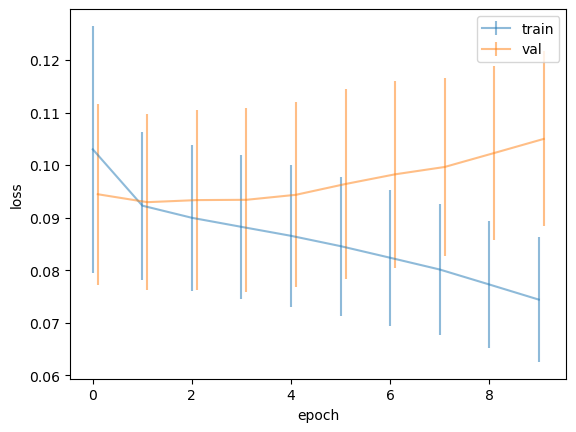

In [10]:
cnn.plot_epochs(box.epochs)

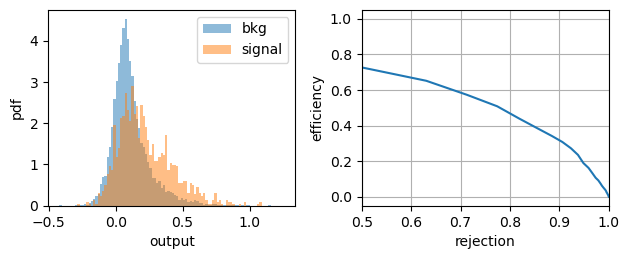

In [11]:
cnn.plot_roc(box.y, box.ypred, 0.5)

## Run

In [146]:
model, dataset, sums, ys, ysp = cnn.run(pressure, bins, epochs = 20)

x labels  ['esum', 'emax', 'emean', 'estd', 'counts']
z labels  ['ext', 'seg']
shapes  (103131, 5, 16, 16) (102481, 5, 16, 16)
['esum', 'emax', 'emean', 'estd', 'counts']
torch.Size([200, 5, 16, 16])
torch.Size([200, 10, 8, 8])
torch.Size([200, 20, 4, 4])
torch.Size([200, 40, 2, 2])
torch.Size([200, 160])
torch.Size([200, 10])
epoch  ((0.2191927890603741, 0.09527358268199414), (0.18307305047812972, 0.015206269398756094))
epoch  ((0.17384204988678295, 0.014554698260681185), (0.17300936391631377, 0.015565654116338931))
epoch  ((0.16719788743389977, 0.013839658785397328), (0.16389067789304604, 0.014913408336142943))
epoch  ((0.16266549991236792, 0.013945406375199258), (0.17059590747055497, 0.01510785193577524))
epoch  ((0.1589572951818506, 0.014414129123096375), (0.15884897026043493, 0.013046836709424999))
epoch  ((0.1558692038887077, 0.014363522414219716), (0.16341783554808606, 0.015108237903999932))
epoch  ((0.15310794045734738, 0.01406202479804646), (0.16406197751899368, 0.015918859265

## Validation

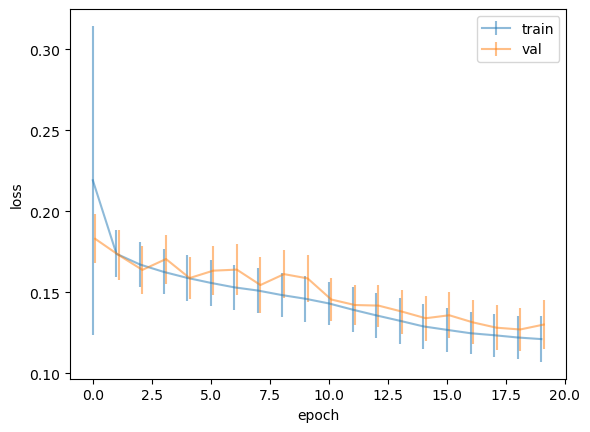

In [147]:
cnn.plot_evolution(sums)

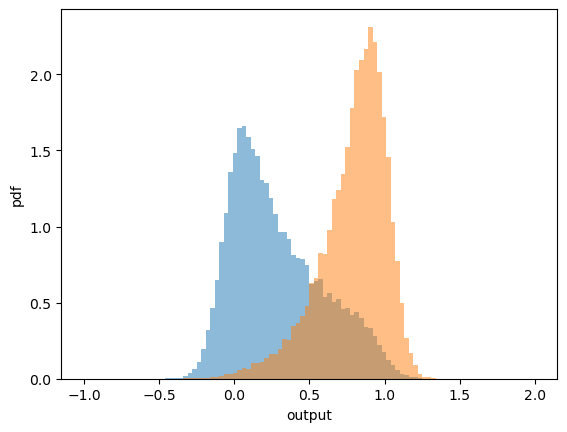

In [148]:
cnn.plot_distributions(ys, ysp)

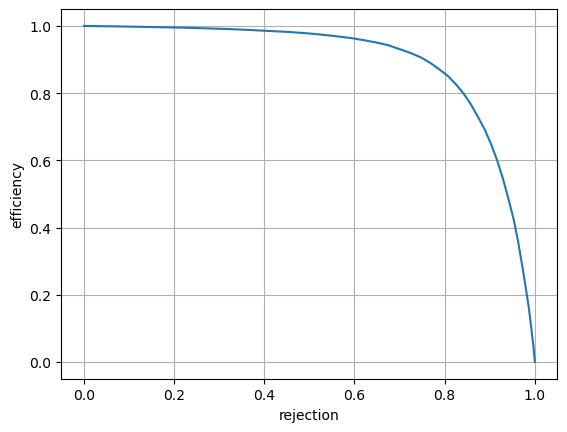

In [149]:
cnn.plot_roc(ys, ysp)

### model

In [319]:
class CNN_C33P11Pool2L1(nn.Module):
    """ Starts from a (8, 8) image, process 3 convolutional layers and a linear layer to a unique output
    """

    def __init__(self, n_depth = 8, n_scale = 2):
        super().__init__()
        self.conv1  = nn.Conv2d(1, n_depth, 3, padding = 1)
        self.bn1    = nn.BatchNorm2d(n_depth)
        self.conv2  = nn.Conv2d(n_depth, n_scale * n_depth, 3, padding = 1)
        self.bn2    = nn.BatchNorm2d( n_scale * n_depth)
        self.pool   = nn.MaxPool2d(2, 2)
        self.fc0    = nn.Linear(4 * n_scale * n_depth, 1)

    def forward(self, x):
        x = self.pool(self.bn1(F.leaky_relu(self.conv1(x))))
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        x = x.flatten(start_dim=1)
        #x = self.drop(x)
        x = self.fc0(x)
        return x
    

class CNN_C33P11Poll2L2(nn.Module):
    """ Starts from a (8, 8) image, process 3 convolutional layers and a linear layer to a unique output
    """

    def __init__(self, n_depth = 8, n_scale = 2):
        super().__init__()
        self.conv1  = nn.Conv2d(1, n_depth, 3, padding = 1)
        self.bn1    = nn.BatchNorm2d(n_depth)
        self.conv2  = nn.Conv2d(n_depth, n_scale * n_depth, 3, padding = 1)
        self.bn2    = nn.BatchNorm2d( n_scale * n_depth)
        self.pool   = nn.MaxPool2d(2, 2)
        self.fc0    = nn.Linear(4 * n_scale * n_depth, n_depth)
        self.fc1    = nn.Linear(n_depth, 1)


    def forward(self, x):
        x = self.pool(self.bn1(F.leaky_relu(self.conv1(x))))
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        x = x.flatten(start_dim=1)
        #x = self.drop(x)
        x = self.fc0(x)
        x = self.fc1(x)
        return x


class CNN_C53P00L2(nn.Module):
    """ Starts from a (8, 8) image, process 3 convolutional layers and a linear layer to a unique output
    """

    def __init__(self, n_depth = 16, n_scale = 2):
        super().__init__()
        self.debug = True
        self.conv1  = nn.Conv2d(1, n_depth, 5, padding = 0)
        self.bn1    = nn.BatchNorm2d(n_depth)
        self.conv2  = nn.Conv2d(n_depth, n_scale * n_depth, 3, padding = 0)
        self.bn2    = nn.BatchNorm2d(n_scale * n_depth)
        self.fc0    = nn.Linear(4 * n_scale * n_depth, n_depth)
        self.fc1    = nn.Linear(n_depth, 1)

    def forward(self, x):
        if (self.debug): print(x.size())
        x = self.bn1(F.leaky_relu(self.conv1(x)));  
        if (self.debug): print(x.size())
        x = self.bn2(F.leaky_relu(self.conv2(x)));  
        if (self.debug): print(x.size())
        x = x.flatten(start_dim=1);
        if (self.debug): print(x.size())
        x = self.fc0(x); 
        if (self.debug): print(x.size())
        x = self.fc1(x)
        self.debug = False
        return x



class CNN_C353P100L2(nn.Module):
    """ Starts from a (8, 8) image, process 3 convolutional layers and a linear layer to a unique output
    """

    def __init__(self, n_depth = 16, n_scale = 2):
        super().__init__()
        self.debug = True
        self.conv1  = nn.Conv2d(1, n_depth, 3, padding = 1)
        self.bn1    = nn.BatchNorm2d(n_depth)
        self.conv2  = nn.Conv2d(n_depth, n_scale * n_depth, 5, padding = 0)
        self.bn2    = nn.BatchNorm2d(n_scale * n_depth)
        self.conv3  = nn.Conv2d(n_scale * n_depth, 2 * n_scale * n_depth, 3, padding = 0)
        self.bn3    = nn.BatchNorm2d(2 * n_scale * n_depth)
        self.fc0    = nn.Linear(4 * 2 * n_scale * n_depth, n_depth)
        self.fc1    = nn.Linear(n_depth, 1)

    def forward(self, x):
        if (self.debug): print('0 > ', x.size())
        x = self.bn1(F.leaky_relu(self.conv1(x)));  
        if (self.debug): print('1 > ', x.size())
        x = self.bn2(F.leaky_relu(self.conv2(x)));  
        if (self.debug): print('2 > ', x.size())
        x = self.bn3(F.leaky_relu(self.conv3(x)));  
        if (self.debug): print('3 > ', x.size())
        x = x.flatten(start_dim=1);
        if (self.debug): print('4 > ', x.size())
        x = self.fc0(x); 
        if (self.debug): print('5 > ', x.size())
        x = self.fc1(x)
        self.debug = False
        return x
    

class CNN_C35P00L2(nn.Module):
    """ Starts from a (8, 8) image, process 3 convolutional layers and a linear layer to a unique output
    """

    def __init__(self, n_depth = 16, n_scale = 2):
        super().__init__()
        self.debug = True
        self.conv1  = nn.Conv2d(1, n_depth, 3, padding = 0)
        self.bn1    = nn.BatchNorm2d(n_depth)
        self.conv2  = nn.Conv2d(n_depth, n_scale * n_depth, 5, padding = 0)
        self.bn2    = nn.BatchNorm2d(n_scale * n_depth)
        self.fc0    = nn.Linear(4 * n_scale * n_depth, n_depth)
        self.fc1    = nn.Linear(n_depth, 1)

    def forward(self, x):
        if (self.debug): print('0 > ', x.size())
        x = self.bn1(F.leaky_relu(self.conv1(x)));  
        if (self.debug): print('1 > ', x.size())
        x = self.bn2(F.leaky_relu(self.conv2(x)));  
        if (self.debug): print('2 > ', x.size())
        x = x.flatten(start_dim=1);
        if (self.debug): print('0 > ', x.size())
        x = self.fc0(x); 
        if (self.debug): print('1 > ', x.size())
        x = self.fc1(x)
        self.debug = False
        return x
    
class CNN_C53P00L2(nn.Module):
    """ Starts from a (8, 8) image, process 3 convolutional layers and a linear layer to a unique output
    """

    def __init__(self, n_depth = 16, n_scale = 2):
        super().__init__()
        self.debug = True
        self.conv1  = nn.Conv2d(1, n_depth, 5, padding = 0)
        self.bn1    = nn.BatchNorm2d(n_depth)
        self.conv2  = nn.Conv2d(n_depth, n_scale * n_depth, 3, padding = 0)
        self.bn2    = nn.BatchNorm2d(n_scale * n_depth)
        self.fc0    = nn.Linear(4 * n_scale * n_depth, n_depth)
        self.fc1    = nn.Linear(n_depth, 1)

    def forward(self, x):
        if (self.debug): print('0 > ', x.size())
        x = self.bn1(F.leaky_relu(self.conv1(x)));  
        if (self.debug): print('1 > ', x.size())
        x = self.bn2(F.leaky_relu(self.conv2(x)));  
        if (self.debug): print('2 > ', x.size())
        x = x.flatten(start_dim=1);
        if (self.debug): print('0 > ', x.size())
        x = self.fc0(x); 
        if (self.debug): print('1 > ', x.size())
        x = self.fc1(x)
        self.debug = False
        return x

In [35]:
def chi2_loss(ys_pred, ys):
    squared_diffs = (ys_pred - ys) ** 2
    return squared_diffs.mean()

In [352]:
def _cuda(xs, ys):
    if torch.cuda.is_available():
        xs = xs.cuda()
        ys = ys.cuda()
        return xs, ys
    return xs, ys

def _training(model, optimizer, train):
    losses = []
    for xs, ys in train:
        xs, ys = _cuda(xs, ys)
        model.train()
        optimizer.zero_grad()
        ys_pred = model(xs)
        loss    = chi2_loss(ys_pred, ys)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())
    return losses

def _validation(model, val):
    losses = []
    with torch.no_grad():
        model.eval()
        for xs, ys in val:
            xs, ys = _cuda(xs, ys)
            ys_pred = model(xs)
            loss    = chi2_loss(ys_pred, ys)
            losses.append(loss.data.item())
    return losses


def _epoch(model, optimizer, train, val):

    losses_train = _training(model, optimizer, train)
    losses_val   = _validation(model, val)

    _sum = lambda x: (np.mean(x), np.std(x))

    val = (_sum(losses_train), _sum(losses_val)) 
    print('epoch ', val)

    return (_sum(losses_train), _sum(losses_val)) 

def train_model(model, optimizer, train, val, nepochs = 20):

    sums = [_epoch(model, optimizer, train, val) for i in range(nepochs)]
    return sums
    

In [37]:
def plot_evolution(sums):
    us  = [sum[0][0] for sum in sums]
    eus = [sum[0][1] for sum in sums]
    vs  = [sum[1][0] for sum in sums]
    evs = [sum[1][1] for sum in sums]
    plt.errorbar(range(len(us)), us, yerr = eus, alpha = 0.5, label = "train")
    plt.errorbar(0.1+np.arange(len(vs)), vs, yerr = evs, alpha = 0.5, label = "val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend();

### Test

In [38]:
def prediction(model, test):
    nys, nys_pred = [], []
    with torch.no_grad():
        model.eval()
        for xs, ys in test:
            xs, ys = _cuda(xs, ys)
            ys_pred = model(xs)
    return ys.numpy(), ys_pred.numpy()

def roc_vals(ys, ys_pred):
    y0 , uedges = np.histogram(ys_pred[ys == 0], bins = 100, range = (-1.5, 1.5), density = True) 
    y1, _       = np.histogram(ys_pred[ys == 1], bins = 100, range = (-1.5, 1.5), density = True) 
    y0c =      np.cumsum(y0)/np.sum(y0)
    y1c = 1. - np.cumsum(y1)/np.sum(y1)
    return y0c, y1c

## Run

In [362]:
NNType    = CNN_C353P100L2
#NNType    = CNN_C53P00L2
#NNType    = CNN_C35P00L2
#NNType    = CNN_C53P00L2 # No so good
pressure  = "13bar"
n_depth   = 32
n_epochs  = 10

In [363]:
dataset = ChessDataset(pressure)

train, test, val = subsets(dataset)

In [364]:
# Load the model.
model = NNType(n_depth = n_depth)

if torch.cuda.is_available():
    model = model.cuda()

# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [365]:
sums = train_model(model, optimizer, train, val, nepochs = n_epochs)

0 >  torch.Size([200, 1, 8, 8])
1 >  torch.Size([200, 32, 8, 8])
2 >  torch.Size([200, 64, 4, 4])
3 >  torch.Size([200, 128, 2, 2])
4 >  torch.Size([200, 512])
5 >  torch.Size([200, 32])
epoch  ((0.21253981166001823, 0.03372150153650682), (0.18906637056938652, 0.013859438408117273))
epoch  ((0.18107156422403123, 0.012859320454080487), (0.17794140044925283, 0.013343772047403751))
epoch  ((0.17200755561805434, 0.013314802061743047), (0.16992964819797035, 0.01272277510938802))
epoch  ((0.1649074233447512, 0.013412540031701657), (0.16721375503586333, 0.01155781092145216))
epoch  ((0.15904726701685123, 0.013494878556780856), (0.16698008558703858, 0.014741131849243272))
epoch  ((0.15404554413010677, 0.013490129677990991), (0.16306533310019855, 0.014094274976951697))
epoch  ((0.14968693910373582, 0.012981312420948073), (0.16155573971641873, 0.013265156001245572))
epoch  ((0.14476171924422185, 0.0132417848579621), (0.16180567949720956, 0.014485005910570583))
epoch  ((0.1401397490873933, 0.0127

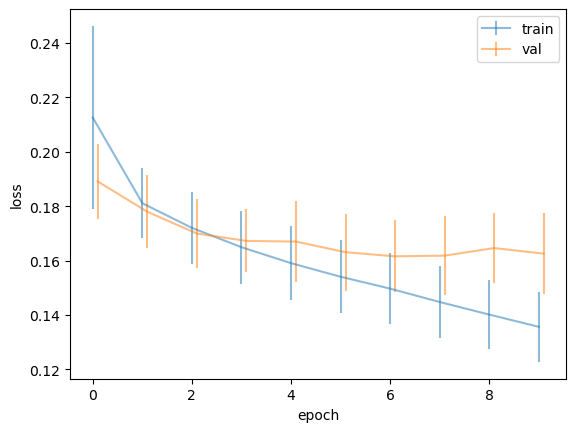

In [366]:
plot_evolution(sums)

In [367]:
ys, ysp = prediction(model, test)

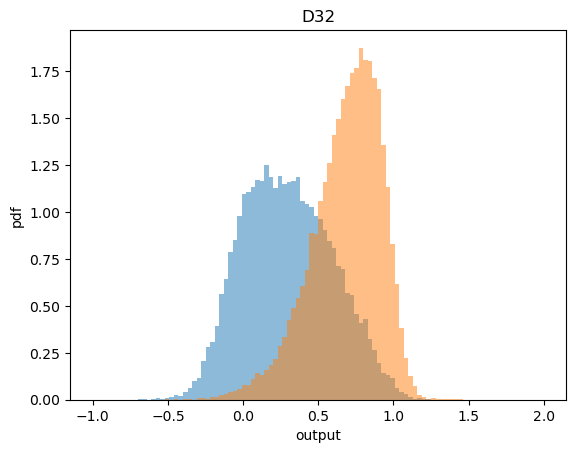

In [368]:
plt.hist(ysp[ys == 0], 100, range = (-1, 2), density = True, alpha = 0.5)
plt.hist(ysp[ys == 1], 100, range = (-1, 2), density = True, alpha = 0.5);
plt.xlabel('output'); plt.ylabel('pdf'); plt.title('D'+str(n_depth));

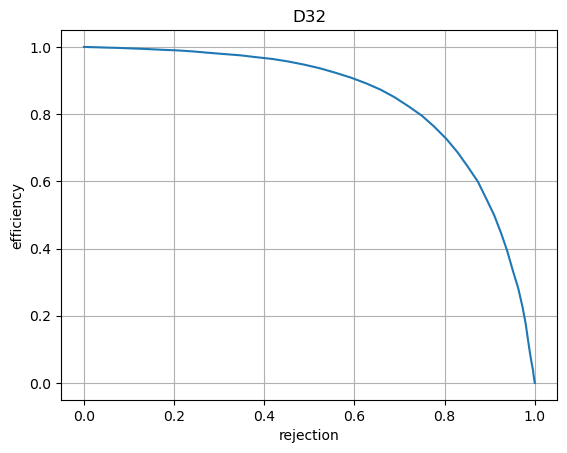

In [369]:
defplot_roc(ys))
y0c, y1c = roc_vals(ys, ysp)
plt.plot(y0c, y1c); plt.grid(); plt.xlabel('rejection'); plt.ylabel("efficiency");  plt.title('D'+str(n_depth));

In [370]:
i0 = np.max(np.argwhere(y1c >= 0.75))
print(y0c[i0], y1c[i0])

0.7765797055680815 0.762966962136028


## Code

In [94]:
def xylabel(xlabel = "x (mm)", ylabel = "y (mm)"):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [6]:
def lstats(var):
    mean, std = np.mean(var), np.std(var)
    comment = "mean = {:.3f} \n std = {:.3f}".format(mean, std)
    return comment

## Prepare Data

In [29]:
m0, n0 = 1, 8
m1, k1, p1 = 6, 3, 0
n1 = (n0 - k1 + 1) / max(p1, 1)
m2, k2, p2 = 12, 3, 0
n2 = (n1 - k2 + 1) / max(p2, 1)

l0 = m2 * n2 * n2
l1 = n0 * n0
l2 = int(l1/2)
l3 = int(l2/2)



In [30]:
print(m0, n0)
print(m1, n1)
print(m2, n2)
print(l0, l1, l2, l3)

1 8
6 6.0
12 4.0
192.0 64 32 16


In [91]:
from datetime import datetime

current_time = datetime.now()
formatted_time = current_time.strftime('%A %d %B %Y')
print(formatted_time)
formatted_time = current_time.strftime('%H:%M:%S')
print(formatted_time)


Thursday 11 April 2024
15:02:46
